Mit diesem Jupyter Notebook wird die **Erreichbarkeit** von **Spielplätzen** in der **Gemeinde Ramsen** (Schweiz) auf Basis der tagesaktuellen Geodaten aus dem eidgenössischen **Gebäude- und Wohnungsregister** (_GWR_) des **Bundesamts für Statistik** (_BfS_) und aus dem kollaborativen **OpenStreetMap**-Datenbestand (_OSM_) untersucht. Dieses Notebook verwendet nur offen zugängliche Datenquellen, sodass die Methoden und Ergebnisse dieser Analyse für alle nachvollziehbar und wiederverwendbar sind.

In der Schweiz gibt es Empfehlungen zur **Erreichbarkeit von Spielplätzen**. Diese Empfehlungen orientieren sich oft an den **Richtlinien** der **DIN 18034**. Laut diesen Richtlinien sollten Spielplätze für **Kinder unter 6 Jahren** in einer Entfernung von **maximal 200 Metern** von ihrer Wohnung erreichbar sein[1]. Für ältere **Kinder bis etwa 12 Jahre** wird eine maximale Entfernung von **400 Metern** empfohlen[1].

Diese Empfehlungen zielen darauf ab, sicherzustellen, dass Kinder **leicht Zugang zu Spielplätzen** haben, ohne dass sie **weite Strecken** zurücklegen müssen. Dies fördert nicht nur die **körperliche Aktivität**, sondern auch die **soziale Interaktion** und das **Wohlbefinden der Kinder**.

Eine Analyse der Gehdistanzen zu den Spielplätze in Ramsen (Schweiz) mit Python-Jupyter.

Quellen:

[1] = [Barsinghausen Spielplatzkonzept Versorgungsanalyse (PDF)](https://www.barsinghausen.de/downloads/datei/I_NMzd4gxoGNCaRdNIuF2WhoalJvbURrRXo0eVBRSklxZytPeUN4bDNUa1lnK3FVMnM2RmVoRmRrNDZ5dGVNWmxTVTlvU1k4YzZsakRva2ROZndrMENKRjNCdlpLSlpxVytaY0Q2T2o5M1Q0R1QxMmlZVG1uTFFmaVBEQzZsL2E1SEdIUitJVk1vWlB4Slg2aUNRMk1TeHpYdDRQVFUzK2p0MzUyZ3BkSmVraU16cUdYNkpqaUs4L21nUT0)

Damit dieses Notebook auch als Labor-Notebook in Google Colab funktioniert, werden als erstes die für die Geodaten-Analyse notwendigen Python-Pakete per Notebook-Zelle installiert:

In [ ]:
!pip install geopandas==0.14.4
!pip install matplotlib==3.9.2
!pip install osmnx==1.9.4
!pip install contextily==1.6.1

Anschliessend können die Bibliotheken für eine Verwendung im Code importiert werden:

In [2]:
import os
import zipfile
import osmnx
import pandas
import geopandas
import contextily
from urllib.request import urlretrieve

Zunächst erfolgt ein Check der OSM-Geodaten der **Gemeindegrenze** von **Ramsen**. Ramsen liegt im **Kanton Schaffhausen** an der Nordgrenze der Schweiz und hat eine **Flächengrösse** von ca. _13.5 qkm_.

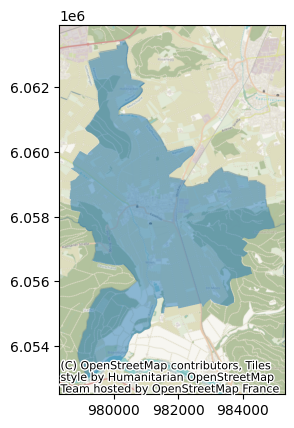

In [3]:
ramsen_grenze = osmnx.geocode_to_gdf("Ramsen, Switzerland")
ramsen_grenze = ramsen_grenze.to_crs(epsg=3857)
ramsen_grenze_plot = ramsen_grenze.plot(alpha=0.5)
contextily.add_basemap(ramsen_grenze_plot)

Als nächstes werden die **öffentlichen Spielplätze** in Ramsen bezogen:

In [4]:
spielplaetze_in_ramsen = osmnx.features_from_place(query="Ramsen, Switzerland", tags={"leisure": "playground"})
spielplaetze_in_ramsen

nodes  \
element_type osmid                                                           
way          1127340227  [10307408520, 10307408519, 10307408518, 103074...   
             1225393718  [11363837562, 11363837561, 11363837560, 113638...   

                            leisure  \
element_type osmid                    
way          1127340227  playground   
             1225393718  playground   

                                                                  geometry  
element_type osmid                                                          
way          1127340227  POLYGON ((8.81620 47.70941, 8.81605 47.70940, ...  
             1225393718  POLYGON ((8.81276 47.70726, 8.81261 47.70730, ...

Dem OSM-Datensatz nach gibt es **zwei** öffentliche Spielplätze in der gesamten Gemeinde Ramsen. Diese sind an den Adressen **Sonnenstrasse 420A** und **Sonnenstrasse 287** zu finden.

KBS in projeziertes KBS ändern, damit geometrische Operationen möglich werden, Tabelle vereinfachen und Zentroid berechnen:

In [5]:
spielplaetze_in_ramsen = spielplaetze_in_ramsen.to_crs(epsg=3857)
spielplaetze_in_ramsen["centroid"] = spielplaetze_in_ramsen.centroid
spielplaetze_in_ramsen = spielplaetze_in_ramsen[["geometry", "centroid"]]
spielplaetze_in_ramsen = spielplaetze_in_ramsen.reset_index()
spielplaetze_in_ramsen

,element_type,osmid,geometry,centroid
0,way,1127340227,"POLYGON ((981415.162 6058646.535, 981397.852 6...",POINT (981403.074 6058655.248)
1,way,1225393718,"POLYGON ((981031.711 6058291.222, 981015.736 6...",POINT (981026.652 6058302.945)


Kartenvorschau der Spielplätze in Ramsen:

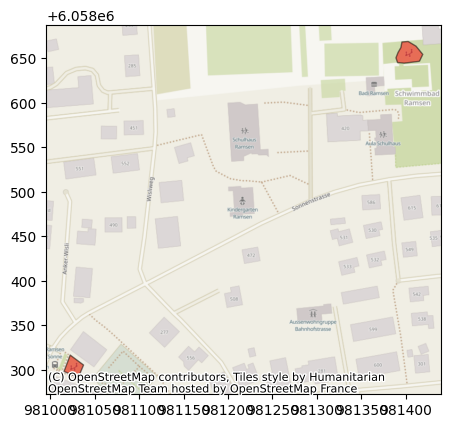

In [6]:
spielplaetze_in_ramsen_plot = spielplaetze_in_ramsen.plot(alpha=0.5, edgecolor='k', color='red')
contextily.add_basemap(spielplaetze_in_ramsen_plot)

Umkreis (Puffer) von _200 Metern_ um die beiden Spielplätze berechnen. Luftlinie als vereinfachte Gehdistanz. Im Einzelfall stark vereinfacht, jedoch in diesem Zusammenhang ist die Vereinfachung akzeptierbar.

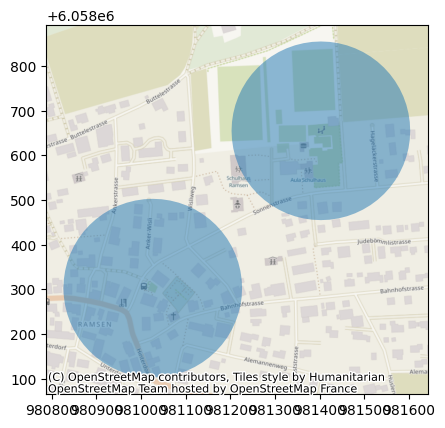

In [7]:
spielplaetze_in_ramsen["buffer"] = spielplaetze_in_ramsen["centroid"].buffer(200)
spielplaetze_in_ramsen_plot = spielplaetze_in_ramsen["buffer"].plot(alpha=0.5)
contextily.add_basemap(spielplaetze_in_ramsen_plot)

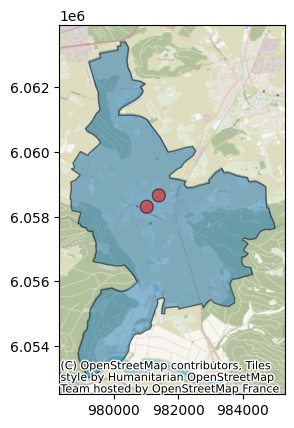

In [8]:
ramsen_grenze_map = ramsen_grenze.to_crs(epsg=3857)
ramsen_grenze_plot = ramsen_grenze_map.plot(alpha=0.5, edgecolor='k')

spielplaetze_in_ramsen_plot = spielplaetze_in_ramsen["buffer"].plot(ax = ramsen_grenze_plot, alpha=0.5, edgecolor='k', color='red')

contextily.add_basemap(spielplaetze_in_ramsen_plot)

In den Folgeschritten werden offizielle Gebäude- und Wohnungsdaten aus dem eidgenössischen _GWR_ des _BfS_ bezogen. Hierzu wird zunächst ein lokaler Ordner für temporäre Daten angelegt:

In [9]:
temp_ordner = "temp"
if not os.path.exists(temp_ordner):
    os.makedirs(temp_ordner)

Als nächstes werden die Geodaten von der MADD-Plattform bezogen:

In [10]:
urlretrieve("https://public.madd.bfs.admin.ch/sh.zip", "temp/sh.zip")

('temp/sh.zip', <http.client.HTTPMessage at 0x179ad07e270>)

ZIP-Datei wird lokal extrahieren:

In [11]:
with zipfile.ZipFile("temp/sh.zip", "r") as sh_archiv:
    sh_archiv.extractall("temp/")

Gebäudedaten aus dem GWR können nun geladen werden:

In [12]:
bfs_gebaeude_sh_gdf = geopandas.read_file("temp/buildings.geojson")
bfs_gebaeude_sh_gdf.head()

,egid,buildingStatus,buildingCategory,buildingClass,municipalityNumber,municipalityName,canton,geometry
0,101204811,1004,1060,1271,2901,Gächlingen,SH,POINT (2679110.508 1284656.239)
1,101204819,1004,1060,0,2901,Gächlingen,SH,POINT (2679575.489 1284227.506)
2,101204820,1004,1020,1110,2901,Gächlingen,SH,POINT (2679748.127 1284539.545)
3,101204851,1004,1020,1110,2901,Gächlingen,SH,POINT (2679535.355 1284314.424)
4,101204852,1004,1020,1110,2901,Gächlingen,SH,POINT (2679520.909 1284303.583)


Der offizielle statistische Gemeindecode von Ramsen lautet **2963**:

In [13]:
gebaeude_ramsen_gdf = bfs_gebaeude_sh_gdf[bfs_gebaeude_sh_gdf["municipalityNumber"] == 2963]
gebaeude_ramsen_gdf["egid"].count()

1179

Stand _Herbst 2024_ hat es insgesamt **1'179 Gebäudeobjekte** im Datenbestand des BfS in Ramsen.

Nur bestende Gebäude (Status 1004):

In [14]:
gebaeude_ramsen_gdf = gebaeude_ramsen_gdf[gebaeude_ramsen_gdf["buildingStatus"] == 1004]
gebaeude_ramsen_gdf["egid"].count()

1086

Gebäude ohne Wohnnutzung entfernen (Kategorie 1060 bedeutet "Gebäude ohne Wohnnutzung"):

In [15]:
wohngebaeude_ramsen_gdf = gebaeude_ramsen_gdf[gebaeude_ramsen_gdf["buildingCategory"] != 1060]
wohngebaeude_ramsen_gdf["egid"].count()

527

Stand _Herbst 2024_ hat es nach offiziellen Quellen insgesamt **527 Wohngebäude** in der Gemeinde Ramsen.

Verteilung der Wohngebäude in Ramsen in der Kartenvorschau:

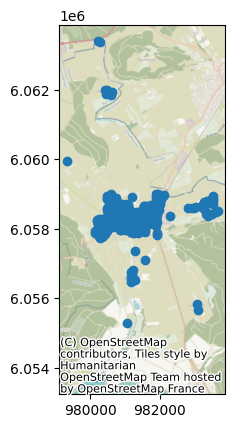

In [16]:
contextily.add_basemap(wohngebaeude_ramsen_gdf.to_crs(epsg=3857).plot())

Mit blossem Auge betrachtet lassen sich in Ramsen **zwei grössere Wohngebiet-Cluster** identifizieren: ein Wohngebiet im **Gemeindezentrum** und eines im Osten ("**Wiesholz**"). Die restlichen Wohnüberbauungen sind im Vergleich dazu dünn und recht stark gestreut.

In [17]:
spielplaetze_puffer_gdf = geopandas.GeoDataFrame(geometry=spielplaetze_in_ramsen["buffer"], crs=3857)
spielplaetze_puffer_gdf = spielplaetze_puffer_gdf.to_crs(epsg=2056)
spielplaetze_puffer_gdf.head()

,geometry
0,"POLYGON ((2703509.766 1285227.040, 2703509.349..."
1,"POLYGON ((2703260.177 1284985.819, 2703259.759..."


In [18]:
gebauede_spielplaetze_200m = geopandas.sjoin(wohngebaeude_ramsen_gdf, spielplaetze_puffer_gdf, how="inner", predicate="intersects")
gebauede_spielplaetze_200m["egid"].count()

66

Es liegen **66 Geäude** in einem Umkreis von 200 Metern um öffentliche Spielplätze in Ramsen.

In [19]:
bfs_wohnungen_sh_df = geopandas.read_file("temp/wohnung_logement_abitazione.csv")
bfs_wohnungen_sh_df.head()

,EGID,EWID,EDID,WHGNR,WEINR,WSTWK,WBEZ,WMEHRG,WBAUJ,WABBJ,WSTAT,WAREA,WAZIM,WKCHE,WEXPDAT,geometry
0,470001,1,0,,,3100,,1,1999,,3004,150,7,1,2024-10-11,None
1,470002,1,0,,,3100,,1,1999,,3004,110,3,1,2024-10-11,None
2,470003,1,0,,,3100,,1,1999,,3004,150,5,1,2024-10-11,None
3,470004,1,0,,,3100,,1,1999,,3004,190,4,1,2024-10-11,None
4,470005,1,0,,,3100,,0,1999,,3004,140,4,1,2024-10-11,None


In [ ]:
bfs_wohnungen_sh_df = bfs_wohnungen_sh_df[bfs_wohnungen_sh_df["WSTAT"] == "3004"]
bfs_wohnungen_sh_df["EGID"].count()

45894

In [21]:
bfs_wohnungen_sh_df["EGID"] = pandas.to_numeric(bfs_wohnungen_sh_df["EGID"])
bfs_wohnungen_sh_df["EGID"].dtype

dtype('int64')

Berechnung Anzahl der Wohnungen in Ramsen insgesamt:

In [22]:
liste_der_egids = wohngebaeude_ramsen_gdf["egid"].to_list()
wohnungen_ramsen = bfs_wohnungen_sh_df[bfs_wohnungen_sh_df["EGID"].isin(liste_der_egids)]
anz_wohnungen_ramsen = wohnungen_ramsen["EGID"].count()
anz_wohnungen_ramsen

809

Stand _Herbst 2024_ hat es **809 Wohnungen** in Ramsen.

Berechnung **Anzahl der Wohnungen** in **200 Meter** Entfernung zu Spielplätzen:

In [23]:
liste_der_egids = gebauede_spielplaetze_200m["egid"].to_list()
wohnungen_um_spielplaetze_200m = bfs_wohnungen_sh_df[bfs_wohnungen_sh_df["EGID"].isin(liste_der_egids)]
anz_wohnungen_200m = wohnungen_um_spielplaetze_200m["EGID"].count()
anz_wohnungen_200m

104

Stand _Herbst 2024_ hat es **104 Wohnungen** in **200 Meter** Entfernung um Spielplätze in Ramsen.

Berechnung prozentualer Anteil 200 Meter Entfernung:

In [24]:
anz_wohnungen_200m /anz_wohnungen_ramsen * 100

12.855377008652658

Stand Herbst 2024 liegen **~ 13 %** der Wohnungen in der Gemeinde Ramsen in einer Entefernung (Luftlinie) von **max. 200 Meter** von einem Spielplatz entfernt.

Eine Abdeckung von **100&nbsp;%** der Wohnungen wäre _unrealistisch_, insbesondere da die Gemeinde Ramsen als ländlicher Ort recht zersiedelt ist. Aber wie viele Spielplätze bräuchte es in Ramsen, um eine Abdeckung von zumindest **50&nbsp;%** aller Wohnungen zu erreichen? Das würde bedeuten, dass zumindest von jeder zweiten Wohnung in Ramsen aus ein Spielplatz in **200&nbsp;m** erreichbar wäre.

Vorschlag für Spielplatz-Standorte (für 200 Meter Puffer) laden:

In [25]:
vorschlag_spielplaetze_200m = geopandas.read_file("input/spielplaetze_200m.geojson")

200 Meter Puffer um Spielplätze erzeugen:

In [26]:
vorschlag_spielplaetze_200m["buffer"] = vorschlag_spielplaetze_200m["geometry"].buffer(200)

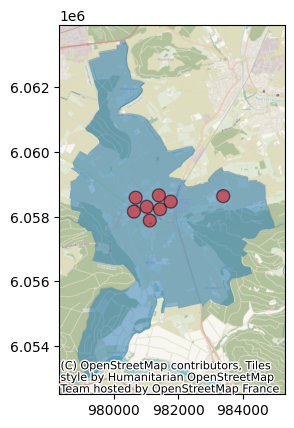

In [27]:
ramsen_grenze = ramsen_grenze.to_crs(epsg=3857)
ramsen_grenze_plot = ramsen_grenze.plot(alpha=0.5)

vorschlag_spielplaetze_200m_plot = vorschlag_spielplaetze_200m["buffer"].plot(ax = ramsen_grenze_plot, alpha=0.5, edgecolor='k', color='red')
contextily.add_basemap(vorschlag_spielplaetze_200m_plot)

Die **Fürsorge-Variante** mit **sechs neuen Spielplätzen** (also dann insgesamt **acht Spielplätze** in ganz Ramsen).

In [28]:
vorschlag_puffer_200_gdf = geopandas.GeoDataFrame(geometry=vorschlag_spielplaetze_200m["buffer"], crs=3857)
vorschlag_puffer_200_gdf = vorschlag_puffer_200_gdf.to_crs(epsg=2056)

In [29]:
gebauede_vorschlag_200m = geopandas.sjoin(wohngebaeude_ramsen_gdf, vorschlag_puffer_200_gdf, how="inner", predicate="intersects")

Kartenansicht der durch den Vorschlag einbezognenen Gebäude:

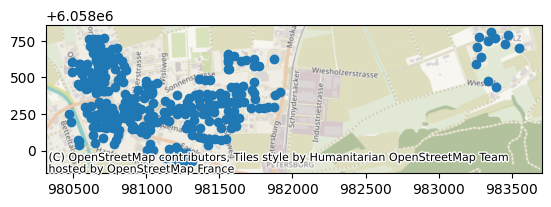

In [30]:
contextily.add_basemap(gebauede_vorschlag_200m.to_crs(epsg=3857).plot())

In [31]:
liste_der_egids = gebauede_vorschlag_200m["egid"].to_list()
wohnungen_vorschlag_200m = bfs_wohnungen_sh_df[bfs_wohnungen_sh_df["EGID"].isin(liste_der_egids)]
anz_wohnungen_vorschlag_200m = wohnungen_vorschlag_200m["EGID"].count()
anz_wohnungen_vorschlag_200m

459

In [32]:
prozent_geb_200m_vorschlag = anz_wohnungen_vorschlag_200m / anz_wohnungen_ramsen * 100
prozent_geb_200m_vorschlag

56.736711990111246

Immerhin **~57 % der Wohnungen** dann in **200-Meter-Reichweite** zu Spielplätzen. Dies würde also immerhin bei 57 % der Wohnungen dafür sorgen, dass die Empfehlungen der DIN 18034 für **Kinder unter 6 Jahren** eingehalten würden.

Ab hier für **400 Meter** berechnen:

In [33]:
vorschlag_spielplaetze_400m = geopandas.read_file("input/spielplaetze_400m.geojson")

In [34]:
vorschlag_spielplaetze_400m["buffer"] = vorschlag_spielplaetze_400m["geometry"].buffer(400)

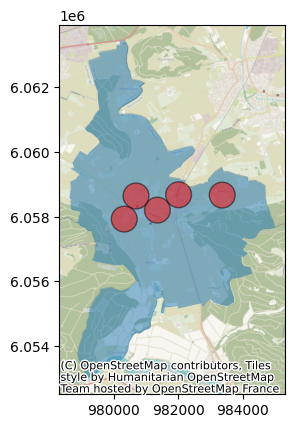

In [35]:
ramsen_grenze_plot = ramsen_grenze.plot(alpha=0.5)
vorschlag_spielplaetze_400m_plot = vorschlag_spielplaetze_400m["buffer"].plot(ax = ramsen_grenze_plot, alpha=0.5, edgecolor='k', color='red')
contextily.add_basemap(vorschlag_spielplaetze_400m_plot)

In [36]:
vorschlag_puffer_400_gdf = geopandas.GeoDataFrame(geometry=vorschlag_spielplaetze_400m["buffer"], crs=3857)
vorschlag_puffer_400_gdf = vorschlag_puffer_400_gdf.to_crs(epsg=2056)

In [37]:
gebauede_vorschlag_400m = geopandas.sjoin(wohngebaeude_ramsen_gdf, vorschlag_puffer_400_gdf, how="inner", predicate="intersects")

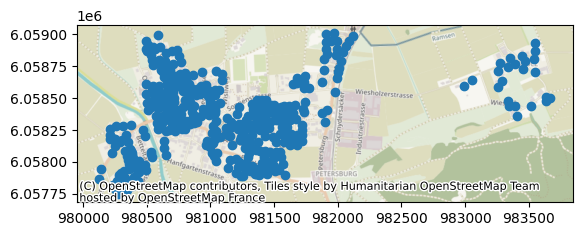

In [38]:
contextily.add_basemap(gebauede_vorschlag_400m.to_crs(epsg=3857).plot())

In [39]:
liste_der_egids = gebauede_vorschlag_400m["egid"].to_list()
wohnungen_vorschlag_400m = bfs_wohnungen_sh_df[bfs_wohnungen_sh_df["EGID"].isin(liste_der_egids)]
anz_wohnungen_vorschlag_400m = wohnungen_vorschlag_400m["EGID"].count()
anz_wohnungen_vorschlag_400m

642

In [40]:
prozent_geb_400m_vorschlag = anz_wohnungen_vorschlag_400m / anz_wohnungen_ramsen * 100
prozent_geb_400m_vorschlag

79.35723114956737